In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm
import sys
sys.path.append('/fs/cbsuvlaminck2/workdir/bmg224/hiprfish/image_analysis_code')
import image_functions as imfn
from segmentation import Segmentation


In [5]:
data_dir = '../data/images'
sample_glob = '*'
sample_names = imfn.get_sample_names(data_dir=data_dir, sample_glob=sample_glob)
refl = ['gfp', 'cy5']
factors = ['method', 'plasmid', 'fov']

print(len(sample_names))

62


In [6]:
sys.path.append('/fs/cbsuvlaminck2/workdir/bmg224/hiprfish/utilities')
import useful_functions_imaging as ufi

In [7]:
keys = ufi.get_filename_keys(sample_names, factors)
len(keys
   )

62

In [8]:
import pandas as pd
spot_int_filenames = [data_dir + '/' + sn + '_spot_seg_cell_id.csv' for sn in sample_names]
spot_int = [pd.read_csv(f) for f in spot_int_filenames]
print(len(spot_int))

62


In [10]:
import numpy as np
cell_seg_filenames = [data_dir + '/' + sn + '_cell_seg.npy' for sn in sample_names]
cell_seg = [np.load(f) for f in cell_seg_filenames]
print(len(cell_seg))

62


In [11]:
cell_props_filenames = [data_dir + '/' + sn + '_cell_seg_props.csv' for sn in sample_names]
cell_props = [pd.read_csv(f) for f in cell_props_filenames]


In [16]:
from skimage.measure import regionprops
def measure_regionprops(_seg, sample_name, fname_mod='_props'):
    regions = regionprops(_seg)
    region_properties = pd.DataFrame(columns = ['ID', 'X', 'Y', 'Area', 'Intensity', 'ParentCellID'])
    for j in range(len(regions)):
        region_properties.loc[j, 'ID'] = regions[j].label
        region_properties.loc[j, 'X'] = regions[j].centroid[1]
        region_properties.loc[j, 'Y'] = regions[j].centroid[0]
        region_properties.loc[j, 'Area'] = regions[j].area
    region_props_filename = sample_name + '_cell_seg_props.csv'
    region_properties.to_csv(region_props_filename)
    return region_properties

cell_props = [measure_regionprops(seg, sn) for seg, sn in zip(cell_seg, sample_names)]

In [12]:
print(cell_props[0].shape)

(1513, 7)


In [13]:
from collections import defaultdict
def group(im_seg_list, g_index):
    im_seg_dict = defaultdict(list) 
    for im_seg in im_seg_list:
        group = im_seg[g_index[0]][g_index[1]]
        im_seg_dict[group].append(im_seg)
    return im_seg_dict


seg_list = zip(keys, spot_int, cell_props)
im_seg_dict = group(seg_list, (0,0))
for g0, s0 in im_seg_dict.items():
    im_seg_dict[g0] = group(s0, (0,1))
#     for g1, s1 in im_seg_dict[g0].items():
#         im_seg_dict[g0][g1] = group(s1, (0,2))
len(im_seg_dict['a'])

2

In [14]:
import matplotlib.pyplot as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

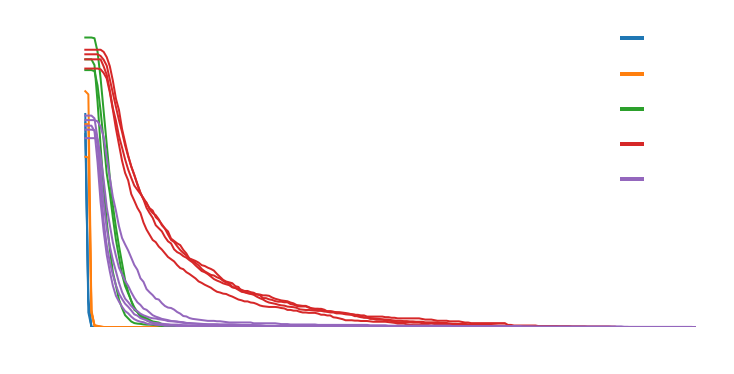

In [18]:
import numpy as np
from matplotlib.lines import Line2D

intensities = []
for sp in spot_int:
    intensities += sp.Intensity.tolist()

phages = ['a','b','c.1','e','h']
times = ['h']
control = 'c'
dims = (10,5)
colors = colors[0:5]
colors_dict = dict(zip(phages,colors))
col = 'w'
ft = 18
thresh_maxs = ['max','max','max','max','max']

fig, ax = plt.subplots(figsize=(dims[0], dims[1]),  tight_layout={'pad': 0})
for phage, thresh_max in zip(phages, thresh_maxs):
    for k, sp, cp in im_seg_dict[phage]['h']:
        cell_count_total = cp.shape[0]
        cell_count_pos = []
        thresh_max = np.max(intensities) if thresh_max =='max' else thresh_max
        thresholds = np.linspace(np.min(intensities), thresh_max, 200)
        for t in thresholds:
            cell_count_pos.append(sp.loc[sp.Intensity >= t, 'cell_id'].unique().shape[0])
        cell_proportion_pos = np.array(cell_count_pos)/cell_count_total
        dcol = colors_dict[k[0]]
        ax.plot(thresholds, cell_proportion_pos, color=dcol, lw=2)
        ax.set_xlabel('Threshold (a.u.)', fontsize=ft, color=col)
        ax.set_ylabel('Proportion of positive cells', fontsize=ft, color=col)
ax.set_ylim(0,1)    
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
            Line2D([0], [0], color=colors[1], lw=4),
            Line2D([0], [0], color=colors[2], lw=4),
            Line2D([0], [0], color=colors[3], lw=4),
            Line2D([0], [0], color=colors[4], lw=4)]
labels = ['Single\nProbe','Ten\nProbes','Amplified\nProbes','Helper\nProbes','Split-HCR\nProbes']
l = ax.legend(custom_lines, labels, loc='upper right', fancybox=True, framealpha=0, )

for text in l.get_texts():
    text.set_color(col)
    text.set_fontsize(ft*4//5)
ax.spines['top'].set_color(col)
ax.spines['bottom'].set_color(col)
ax.spines['left'].set_color(col)
ax.spines['right'].set_color(col)
ax.tick_params(direction='in', color=col, labelcolor=col, labelsize=ft*4//5) 

output_filename = '../figures/threshold_curves.png'
plt.savefig(output_filename, transparent=True, dpi=500)


#     for k, sp, cp in im_seg_dict[phage]['h']:
#         cell_count_total = cp.shape[0]
#         cell_count_pos = []
#         thresh_max = np.max(intensities) if thresh_max =='max' else thresh_max
#         thresholds = np.linspace(np.min(intensities), thresh_max, 200)
#         for t in thresholds:
#             cell_count_pos.append(sp.loc[sp.Intensity >= t, 'cell_id'].unique().shape[0])
#         cell_proportion_pos = np.array(cell_count_pos)/cell_count_total
#         dcol = colors_dict[k[0]]
#         ax.plot(thresholds, cell_proportion_pos, color=dcol, lw=2)
#         ax.set_xlabel('Threshold (a.u.)', fontsize=ft, color=col)
#         ax.set_ylabel('Proportion of positive cells', fontsize=ft, color=col)
